In [90]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [91]:
import pandas as pd
import numpy as np
import seaborn as sb

# for reproducibility of results
np.random.seed(12345)

from datetime import date
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

In [92]:
# pre-set the plot font sizes...

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)      # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)     # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)   # fontsize of the figure title

In [93]:
def get_mape(y_true, y_pred):
    """
    Compute Mean Absolute Percentage Error (MAPE)

    INPUT:
    y_true - actual variable
    y_pred - predicted variable

    OUTPUT:
    mape - Mean Absolute Percentage Error (%)

    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)

    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    return mape

def get_rmse(y_true, y_pred):
    """
    Compute Root Mean Squared Error (RMSE)

    INPUT:
    y_true - actual variable
    y_pred - predicted variable

    OUTPUT:
    rmse - Root Mean Squared Error

    """
    rmse = np.sqrt(np.mean(np.power((y_true - y_pred),2)))

    return rmse

# **Explotary Analysis**

In [94]:
df = pd.read_csv('drive/MyDrive/question4-stock-data.csv')
df.shape


(11291, 8)

In [95]:
df.dtypes

,0
Unnamed: 0,int64
Date,object
Adj Close,float64
Close,float64
High,float64
Low,float64
Open,float64
Volume,float64


In [96]:
# Convert Date column to datetime format
df["Date"] = pd.to_datetime(df["Date"], format = '%Y-%m-%d',errors="coerce")

In [97]:

# display top 10 observations of the dataset
df.head(10)

,Unnamed: 0,Date,Adj Close,Close,High,Low,Open,Volume
0,0,1980-03-17,2.296798,3.291227,3.344743,3.291227,0.000000,41109.0
1,1,1980-03-18,2.306134,3.304606,3.358122,3.304606,0.000000,9343.0
2,2,1980-03-19,2.306134,3.304606,3.304606,3.304606,3.304606,0.0
3,3,1980-03-20,2.306134,3.304606,3.358122,3.304606,0.000000,10277.0
4,4,1980-03-21,2.362154,3.384880,3.438396,3.384880,0.000000,8409.0
5,5,1980-03-24,2.371490,3.398259,3.451775,3.398259,0.000000,2803.0
6,6,1980-03-25,2.352816,3.371501,3.425017,3.371501,0.000000,27095.0
7,7,1980-03-26,2.352816,3.371501,3.425017,3.371501,0.000000,1869.0
8,8,1980-03-27,2.324807,3.331364,3.384880,3.331364,0.000000,14015.0
9,9,1980-03-28,2.315470,3.317985,3.371501,3.317985,0.000000,36438.0


In [98]:
# sumarize numerical features
df.describe()

,Unnamed: 0,Date,Adj Close,Close,High,Low,Open,Volume
count,11291.000000,11181,11198.000000,11174.000000,11196.000000,11164.000000,11188.000000,1.114600e+04
mean,5645.000000,2002-08-03 13:57:54.429836288,63.609130,72.026945,72.503100,71.665079,67.999259,2.144157e+05
min,0.000000,1980-03-17 00:00:00,2.259452,3.237711,3.237711,3.237711,0.000000,0.000000e+00
25%,2822.500000,1991-05-17 00:00:00,19.224636,27.500000,27.789255,27.536156,0.000000,1.350000e+04
50%,5645.000000,2002-07-26 00:00:00,50.608900,66.035000,66.724998,65.418751,66.065002,9.032350e+04
75%,8467.500000,2013-10-21 00:00:00,104.723621,114.297503,114.892500,113.639999,114.269997,2.915750e+05
max,11290.000000,2024-12-27 00:00:00,254.770004,254.770004,255.229996,253.589996,255.000000,1.858270e+07
std,3259.575279,NaN,52.266247,51.259828,51.550735,51.011632,55.834401,3.883662e+05


In [99]:
df = df.drop(columns=['Unnamed: 0', 'Adj Close'])

In [100]:
#Univariate Analysis (Summary Statistics)
df.describe()

,Date,Close,High,Low,Open,Volume
count,11181,11174.000000,11196.000000,11164.000000,11188.000000,1.114600e+04
mean,2002-08-03 13:57:54.429836288,72.026945,72.503100,71.665079,67.999259,2.144157e+05
min,1980-03-17 00:00:00,3.237711,3.237711,3.237711,0.000000,0.000000e+00
25%,1991-05-17 00:00:00,27.500000,27.789255,27.536156,0.000000,1.350000e+04
50%,2002-07-26 00:00:00,66.035000,66.724998,65.418751,66.065002,9.032350e+04
75%,2013-10-21 00:00:00,114.297503,114.892500,113.639999,114.269997,2.915750e+05
max,2024-12-27 00:00:00,254.770004,255.229996,253.589996,255.000000,1.858270e+07
std,NaN,51.259828,51.550735,51.011632,55.834401,3.883662e+05


<ipython-input-101-9d85ad78ee05>:8: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


<ipython-input-101-9d85ad78ee05>:8: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


<ipython-input-101-9d85ad78ee05>:8: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use

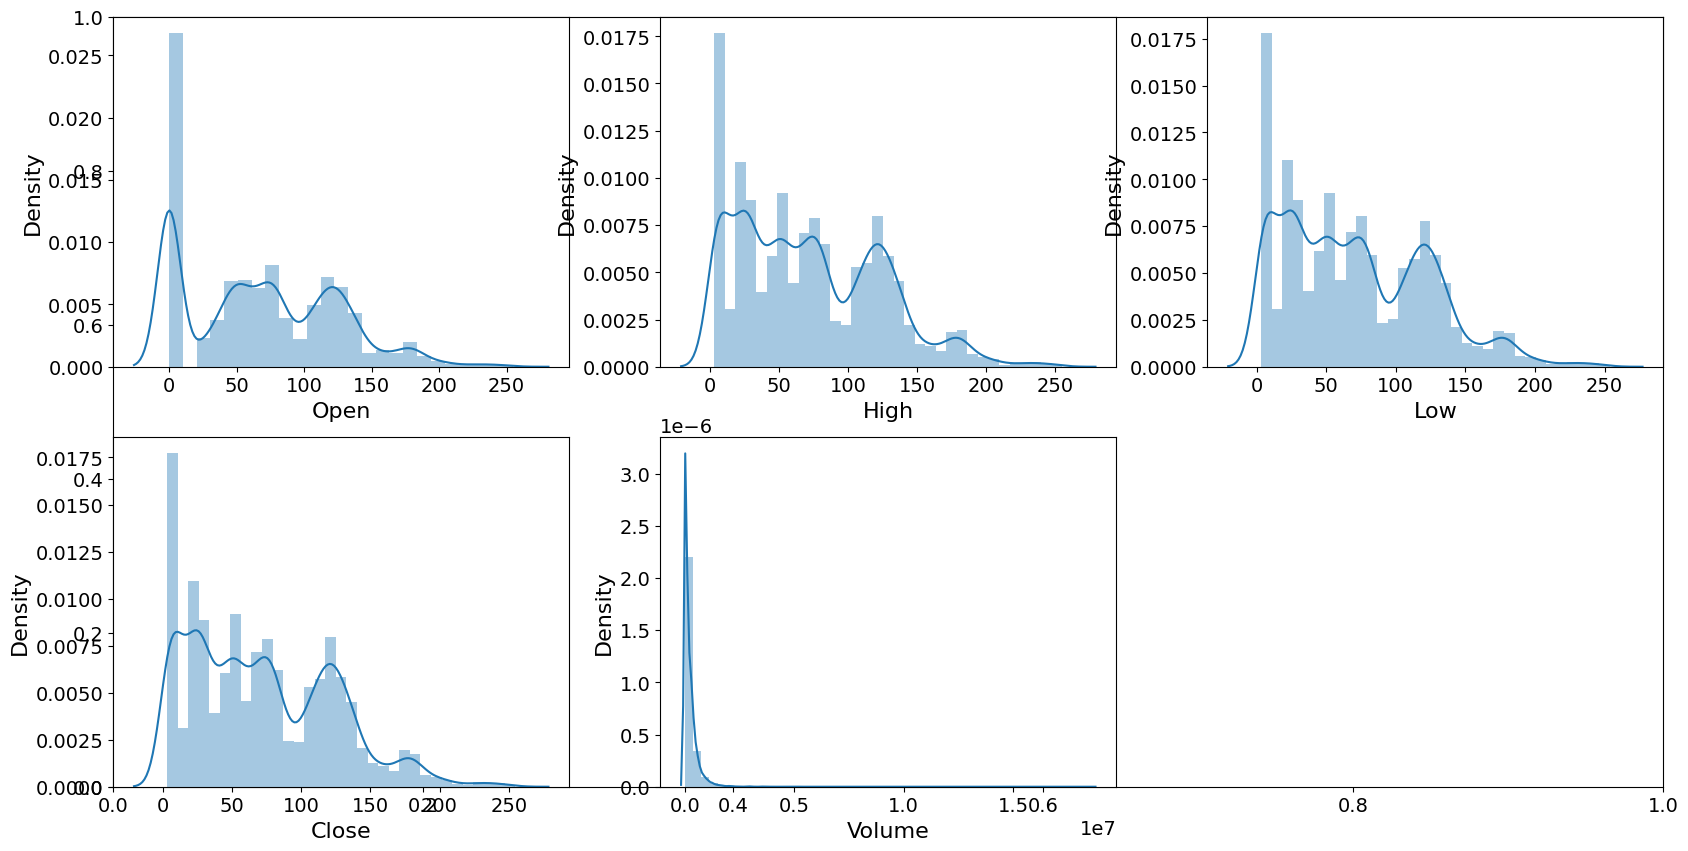

1

In [101]:
#data distribution histograms
features = ['Open', 'High', 'Low', 'Close', 'Volume']

plt.subplots(figsize=(20,10))

for i, col in enumerate(features):
  plt.subplot(2,3,i+1)
  sb.distplot(df[col])
plt.show()
1

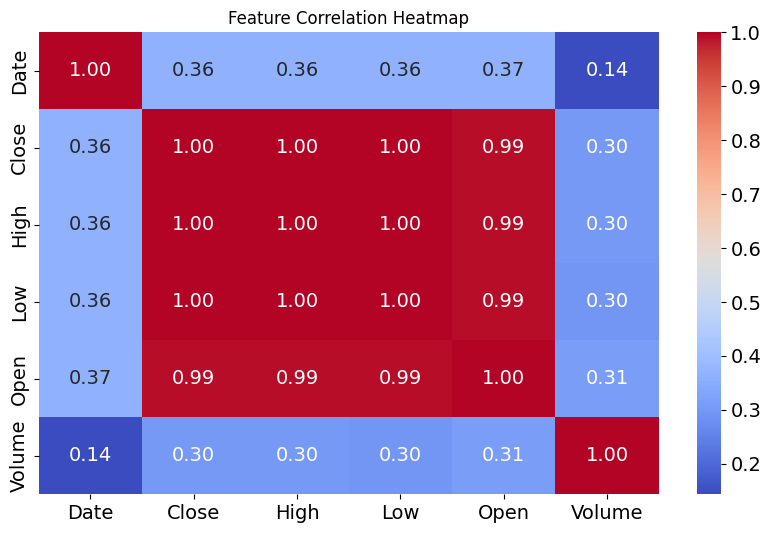

In [102]:
#Checking for Correlations
import seaborn as sns

plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

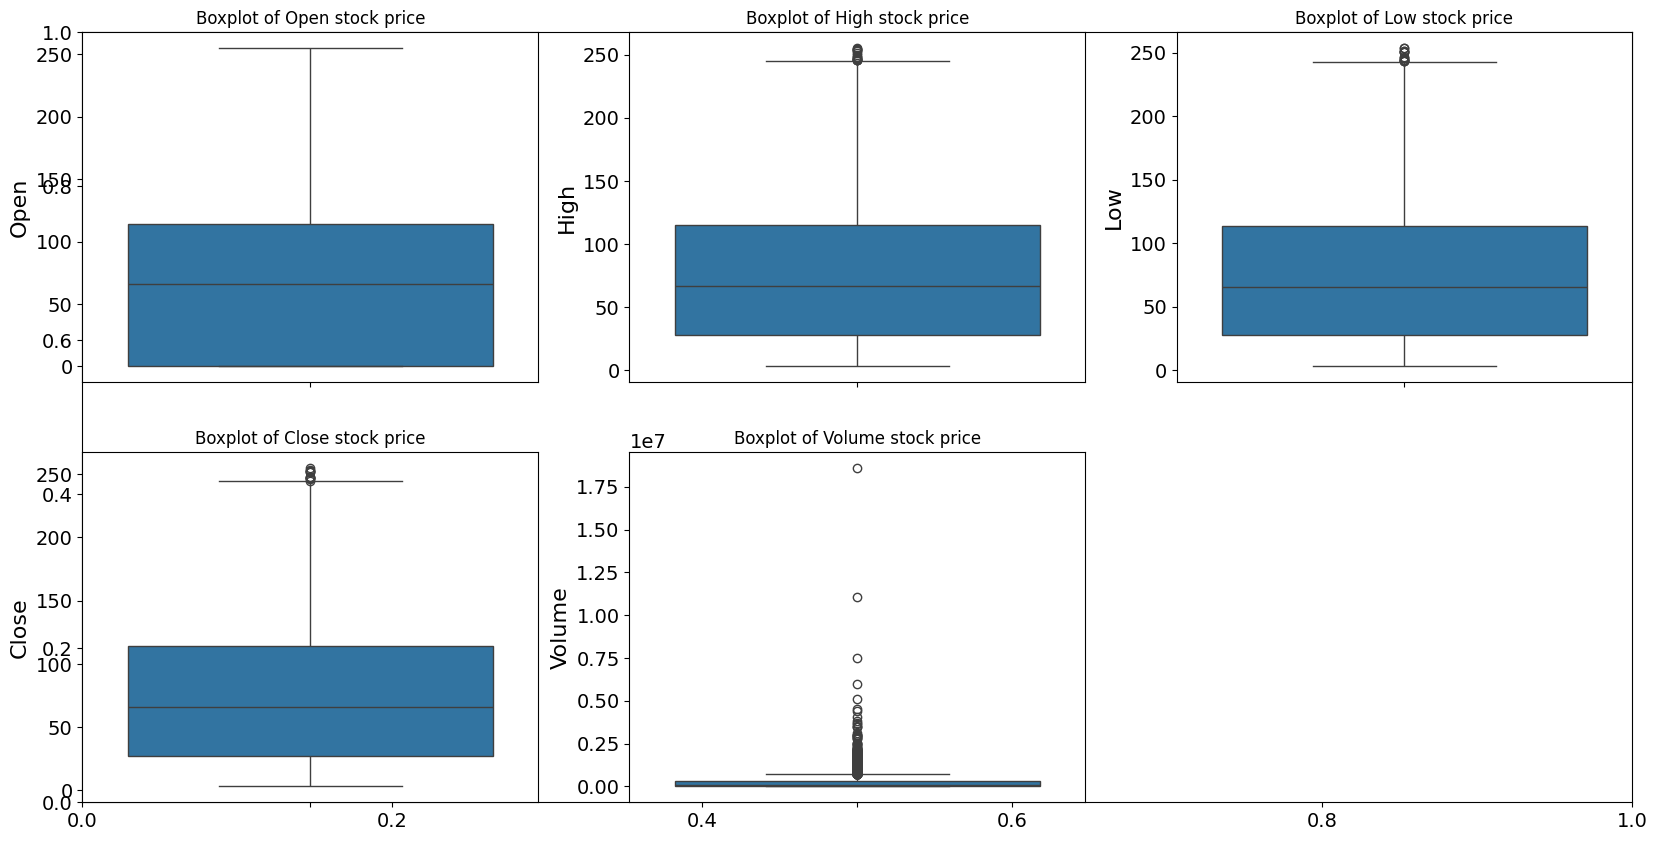

In [103]:
#detecting outliers
plt.subplots(figsize=(20,10))
for i, col in enumerate(features):
  plt.subplot(2,3,i+1)
  plt.title(f"Boxplot of {features[i]} stock price")
  sb.boxplot(df[col])
plt.show()


        Date     Close      High       Low      Open   Volume
0 1980-03-17  3.291227  3.344743  3.291227  0.000000  41109.0
1 1980-03-18  3.304606  3.358122  3.304606  0.000000   9343.0
2 1980-03-19  3.304606  3.304606  3.304606  3.304606      0.0
3 1980-03-20  3.304606  3.358122  3.304606  0.000000  10277.0
4 1980-03-21  3.384880  3.438396  3.384880  0.000000   8409.0
<class 'pandas.core.frame.DataFrame'>
Index: 10058 entries, 0 to 11288
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    9958 non-null   datetime64[ns]
 1   Close   10058 non-null  float64       
 2   High    10058 non-null  float64       
 3   Low     10058 non-null  float64       
 4   Open    10058 non-null  float64       
 5   Volume  10058 non-null  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 550.0 KB
None


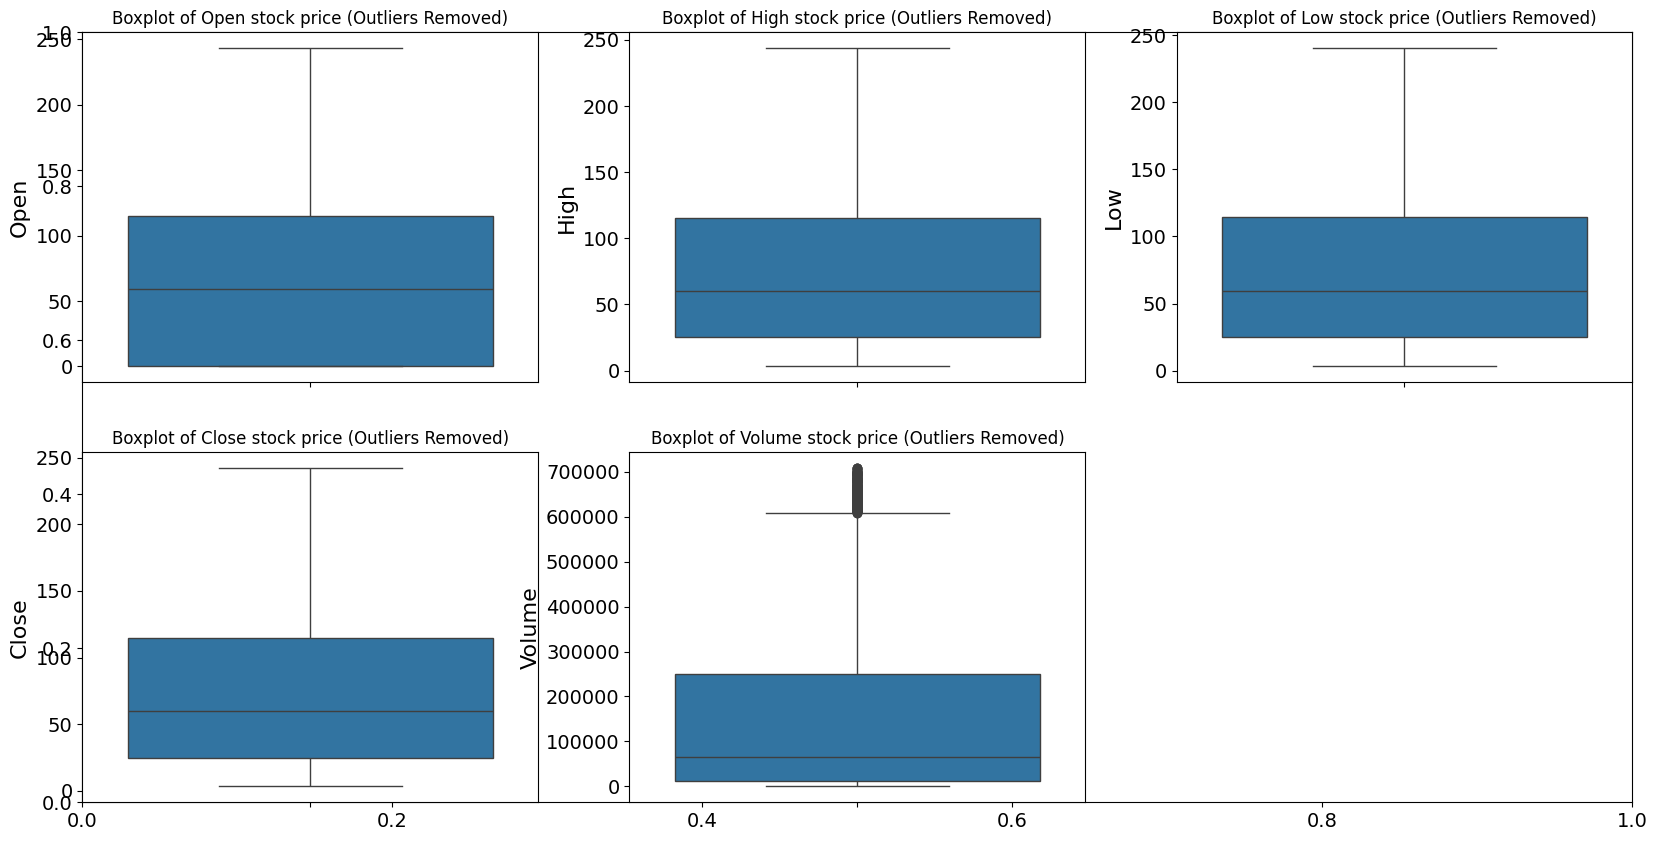

In [104]:
def remove_outliers(df, features):
    """Removes outliers from specified features in a Pandas DataFrame using the IQR method.

    Args:
        df: The input DataFrame.
        features: A list of column names representing the features to process.

    Returns:
        A new DataFrame with outliers removed.
    """
    df_no_outliers = df.copy()  # Create a copy to avoid modifying the original DataFrame
    for col in features:
        Q1 = df_no_outliers[col].quantile(0.25)
        Q3 = df_no_outliers[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Remove rows where the feature value is outside the bounds
        df_no_outliers = df_no_outliers[
            (df_no_outliers[col] >= lower_bound) & (df_no_outliers[col] <= upper_bound)
        ]

    return df_no_outliers

# Example usage (assuming 'df' and 'features' are already defined):
features = ['Open', 'High', 'Low', 'Close', 'Volume']
df_cleaned = remove_outliers(df, features)

# Display the cleaned data
print(df_cleaned.head())
print(df_cleaned.info())

# Visualize the cleaned data (optional)
plt.subplots(figsize=(20,10))
for i, col in enumerate(features):
  plt.subplot(2,3,i+1)
  plt.title(f"Boxplot of {features[i]} stock price (Outliers Removed)")
  sb.boxplot(df_cleaned[col])
plt.show()

# **Data Preprocessing**


In [105]:
# sort by datetime
df.sort_values(by='Date', inplace=True, ascending=True)

In [106]:
duplicates = df.duplicated().sum()
missing_values = df.isnull().sum()

duplicates, missing_values

(0,
 Date      110
 Close     117
 High       95
 Low       127
 Open      103
 Volume    145
 dtype: int64)

In [107]:
# Drop rows with missing values
df = df.dropna()

In [108]:
missing_values_after_cleaning = df.isnull().sum()
missing_values_after_cleaning

,0
Date,0
Close,0
High,0
Low,0
Open,0
Volume,0


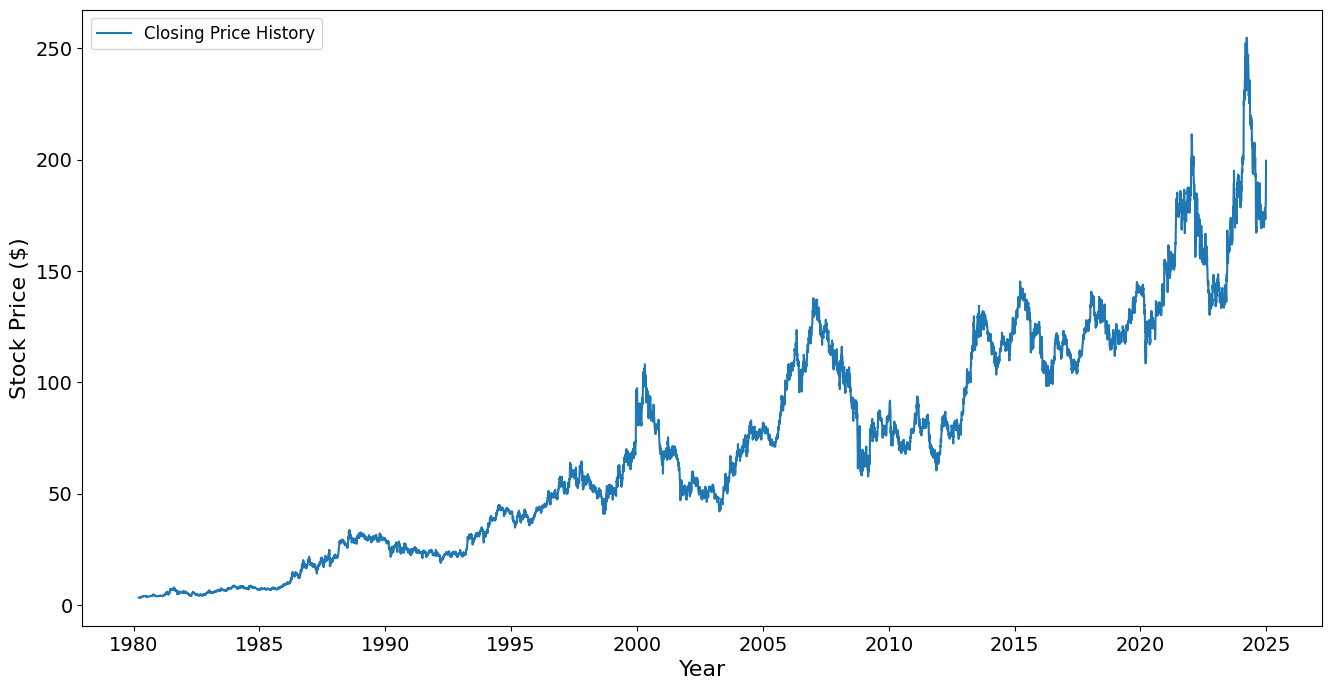

In [109]:
plt.figure(figsize = (16,8))
plt.plot(df['Date'], df['Close'], label = 'Closing Price History')
plt.legend(loc = "upper left")
plt.xlabel('Year')
plt.ylabel('Stock Price ($)')
plt.show()

In [110]:

test_size = 0.2
training_size = 1 - test_size

test_num = int(test_size * len(df))
train_num = int(training_size * len(df))

print("train_num: " + str(train_num))
print("test_num: " + str(test_num))

train_num: 8492
test_num: 2123


In [112]:
train = df[:train_num][['Date', 'Close']]
test = df[train_num:][['Date', 'Close']]

# **Moving Average Algorithm**

In [113]:
preds = []

for i in range(0, test.shape[0]):
    a = train['Close'][len(train) - test.shape[0] + i:].sum() + test['Close'][:i].sum()
    b = a/test.shape[0]
    preds.append(b)

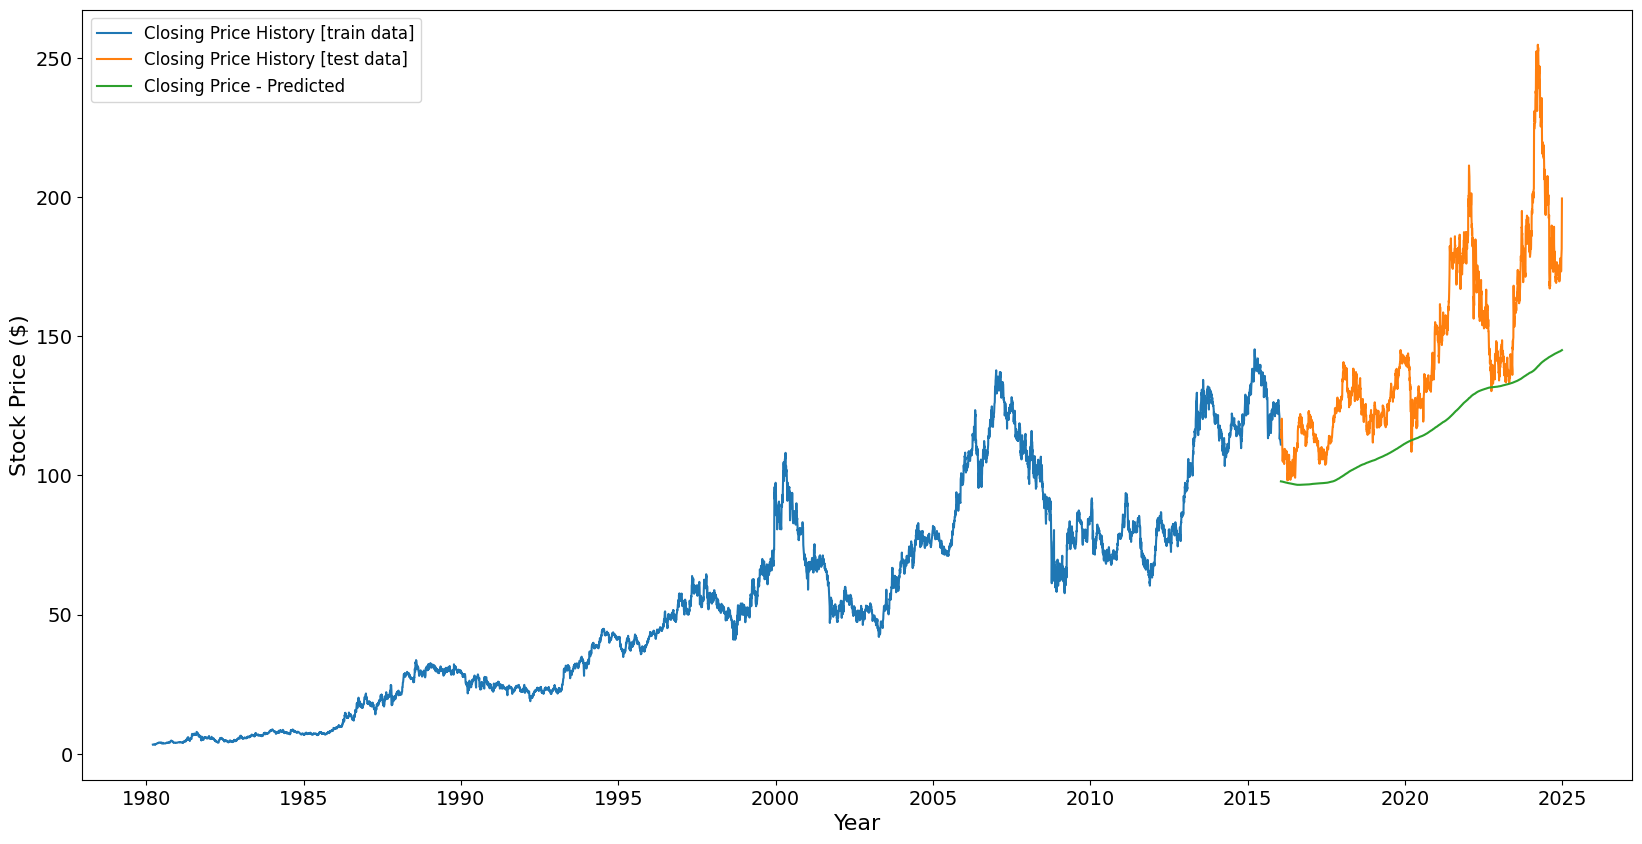

In [114]:

# Plot predicted price vs actual closing price

test['Predictions_ma'] = preds
plt.figure(figsize = (20,10))
plt.xlabel('Year')
plt.ylabel('Stock Price ($)')
plt.plot(train['Date'], train['Close'], label = 'Closing Price History [train data]')
plt.plot(test['Date'], test['Close'], label = 'Closing Price History [test data]')
plt.plot(test['Date'], test['Predictions_ma'], label = 'Closing Price - Predicted')
plt.legend(loc = "upper left")
plt.show()

In [115]:
# Evaluate performance
rmse_ma = get_rmse(np.array(test['Close']), np.array(test['Predictions_ma']))
print('Root Mean Squared Error: ' + str(rmse_ma))
mape_ma = get_mape(np.array(test['Close']), np.array(test['Predictions_ma']))
print('Mean Absolute Percentage Error (%): ' + str(mape_ma))

Root Mean Squared Error: 35.08731882683618
Mean Absolute Percentage Error (%): 18.100208720725362


# **LSTM Algorithm**
Long Short Term Memory

In [116]:
#Standardise all our feature variables to the same scale
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Close']])
scaled_data_train = scaled_data[:train.shape[0]]

In [117]:
# create a useful function to split our data into X and y

def get_x_y(data, N, offset):
    """
    Split data into input variable (X) and output variable (y)

    INPUT:
    data - dataset to be splitted
    N - time frame to be used
    offset - position to start the split

    OUTPUT:
    X - input variable
    y - output variable
    """
    X, y = [], []

    for i in range(offset, len(data)):
        X.append(data[i-N:i])
        y.append(data[i])

    X = np.array(X)
    y = np.array(y)

    return X, y

In [118]:
# using past 60 days stock prices for our training to predict 61th day's closing price.

X_train, y_train = get_x_y(scaled_data_train, 60, 60)

In [121]:
# initial LSTM parameters
lstm_units = 50
optimizer = 'adam'
epochs = 1
batch_size = 1

model = Sequential()
model.add(LSTM(units = lstm_units, return_sequences = True, input_shape = (X_train.shape[1],1)))
model.add(LSTM(units = lstm_units))
model.add(Dense(1))

In [122]:

# Compile and fit the LSTM network
model.compile(loss = 'mean_squared_error', optimizer = 'adam')
model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, verbose = 2)

8432/8432 - 215s - 26ms/step - loss: 1.8624e-04


In [135]:
# predict stock prices using past 60 stock prices
inputs = df['Close'][len(df) - len(test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)


X_test = []
for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

 9/67 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


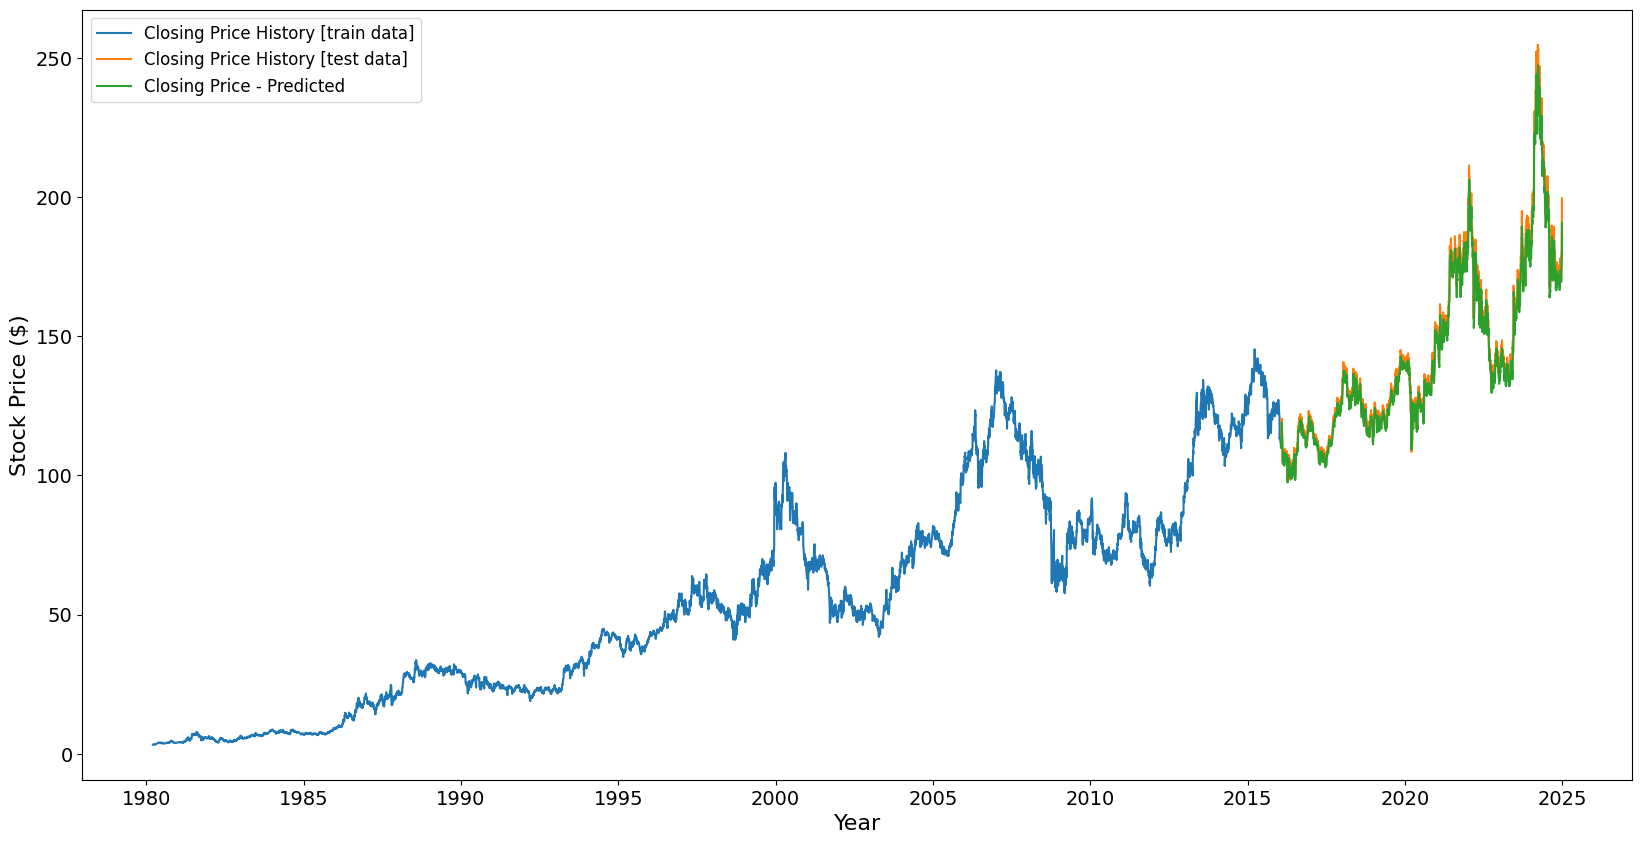

In [136]:
# Plot predicted price vs actual closing price

test['Predictions_lstm'] = closing_price
plt.figure(figsize = (20,10))
plt.xlabel('Year')
plt.ylabel('Stock Price ($)')
plt.plot(train['Date'], train['Close'], label = 'Closing Price History [train data]')
plt.plot(test['Date'], test['Close'], label = 'Closing Price History [test data]')
plt.plot(test['Date'], test['Predictions_lstm'], label = 'Closing Price - Predicted')
plt.legend(loc = "upper left")
plt.show()

In [138]:
# Evaluate performance
rmse_lstm = get_rmse(np.array(test['Close']), np.array(test['Predictions_lstm']))
mape_lstm = get_mape(np.array(test['Close']), np.array(test['Predictions_lstm']))
print('Root Mean Squared Error: ' + str(rmse_lstm))
print('Mean Absolute Percentage Error (%): ' + str(mape_lstm))

Root Mean Squared Error: 3.6845844075047456
Mean Absolute Percentage Error (%): 1.8623630531744513



# **Model Performance Comparison**

comparing Moving Avarage and LSTM

In [139]:

d = {'Metric':['RMSE','MAPE (%)'],
     'Moving Average': [rmse_ma, mape_ma],
     'LSTM': [rmse_lstm, mape_lstm]

}

comp_table = pd.DataFrame(d)
comp_table

,Metric,Moving Average,LSTM
0,RMSE,35.087319,3.684584
1,MAPE (%),18.100209,1.862363


Winning model *LSTM*


# **Tune Hyperparameters for LSTM**

Create functions based on the previous code that allow us to easily input specific hyperparameters into the LSTM model and calculate RMSE and MAPE, so we can get the results with just a few lines of code.

In [141]:
# create, compile and fit LSTM netork.
def fit_lstm(X_train, y_train, lstm_units = 50, optimizer = 'adam', epochs = 1,
             batch_size = 1, loss = 'mean_squared_error'):
    """
    INPUT:
    X_train - training input variables (X)
    y_train - training output variable (y)

    default(initial) parameters chosen for LSTM
    --------------------------------------------
    lstm_units = 50
    optimizer = 'adam'
    epochs = 1
    batch_size = 1
    loss = 'mean_squared_error'

    OUTPUT:
    model - fitted model
    """
    model = Sequential()
    model.add(LSTM(units = lstm_units, return_sequences = True, input_shape = (X_train.shape[1],1)))
    model.add(LSTM(units = lstm_units))
    model.add(Dense(1))

    model.compile(loss = 'mean_squared_error', optimizer = 'adam')
    model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, verbose = 1)
    # verbose changed to 1 to show the animated progress...
    return model

# predict stock price using past 60 stock prices
def get_pred_closing_price(df, scaler, model):
    """
    INPUT:
    df - dataframe that has been preprocessed
    scaler - instantiated object for MixMaxScaler()
    model - fitted model

    OUTPUT:
    closing_price - predicted closing price using fitted model
    """
    inputs = df['Close'][len(df) - len(test) - 60:].values
    inputs = inputs.reshape(-1,1)
    inputs = scaler.transform(inputs)

    X_test = []
    for i in range(60, inputs.shape[0]):
        X_test.append(inputs[i-60:i,0])
    X_test = np.array(X_test)

    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    closing_price = model.predict(X_test)
    closing_price = scaler.inverse_transform(closing_price)
    return closing_price

# evaluate model performance
def model_performance(test, closing_price):
    """
    INPUT:
    test - test dataset that contains only 'Date' & 'Close' columns (i.e.test = df[train_num:][['Date', 'Close']])
    closing_price - predicted closing price using fitted model

    OUTPUT:
    rmse_lstm - RMSE for LSTM
    mape_lstm - MAPE(%) for LSTM
    """
    test['Predictions_lstm_tuned'] = closing_price
    rmse_lstm = get_rmse(np.array(test['Close']), np.array(test['Predictions_lstm_tuned']))
    mape_lstm = get_mape(np.array(test['Close']), np.array(test['Predictions_lstm_tuned']))
    print('Root Mean Squared Error: ' + str(rmse_lstm))
    print('Mean Absolute Percentage Error (%): ' + str(mape_lstm))
    return rmse_lstm, mape_lstm

#================================================================================
# train, predict, evaluate model
def train_pred_eval_model(X_train, y_train, df, scaler, test,
                          lstm_units = 50, optimizer = 'adam', epochs = 1,
                          batch_size = 1, loss = 'mean_squared_error'):
    """
    INPUT:
    X_train - training input variables (X)
    y_train - training output variable (y)
    df - dataframe that has been preprocessed
    scaler - instantiated object for MixMaxScaler()
    test - test dataset that contains only 'Date' & 'Close' columns (i.e.test = df[train_num:][['Date', 'Close']])

    default(initial) parameters chosen for LSTM
    --------------------------------------------
    lstm_units = 50
    optimizer = 'adam'
    epochs = 1
    batch_size = 1
    loss = 'mean_squared_error'

    OUTPUT:
    rmse_lstm - RMSE for LSTM
    mape_lstm - MAPE(%) for LSTM
    """
    model_tuned = fit_lstm(X_train, y_train, int(lstm_units), optimizer, int(epochs),
             int(batch_size), loss)
    closing_price_tuned = get_pred_closing_price(df, scaler, model_tuned)
    rmse_lstm, mape_lstm = model_performance(test, closing_price_tuned)
    return rmse_lstm, mape_lstm


# **Tune Model - epochs**
tuning the number of training epochs.



In [142]:
# Test epochs range from 1 to 4 using a for loop, print the RMSE and MAPE results and store results in a dataframe
# the rest of the lstm parameters are the initial paramaters

epoch_ls, rmse_ls, mape_ls = [], [], []

epochs_range = [1, 2, 3, 4]
for i in epochs_range:
    print('epochs = '+ str(i))
    print('============')
    rmse_lstm, mape_lstm = train_pred_eval_model(X_train, y_train, df, scaler, test, epochs = i)

    epoch_ls.append(i)
    rmse_ls.append(rmse_lstm)
    mape_ls.append(mape_lstm)

    print(" ")

col_names = ['Epoch', 'RMSE', 'MAPE']
df_epoch = pd.DataFrame(list(zip(epoch_ls, rmse_ls, mape_ls)),
                       columns = col_names)

epochs = 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



8432/8432 ━━━━━━━━━━━━━━━━━━━━ 240s 28ms/step - loss: 3.5501e-04


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
Root Mean Squared Error: 4.44145505797901
Mean Absolute Percentage Error (%): 2.9202699928315936
 
epochs = 2
Epoch 1/2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



8432/8432 ━━━━━━━━━━━━━━━━━━━━ 235s 28ms/step - loss: 6.6381e-04
Epoch 2/2
8432/8432 ━━━━━━━━━━━━━━━━━━━━ 259s 27ms/step - loss: 7.2753e-05


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
Root Mean Squared Error: 3.0134411006087567
Mean Absolute Percentage Error (%): 1.7502129929257995
 
epochs = 3
Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



8432/8432 ━━━━━━━━━━━━━━━━━━━━ 236s 28ms/step - loss: 3.7453e-04
Epoch 2/3
8432/8432 ━━━━━━━━━━━━━━━━━━━━ 260s 27ms/step - loss: 6.5579e-05
Epoch 3/3
8432/8432 ━━━━━━━━━━━━━━━━━━━━ 229s 27ms/step - loss: 5.9544e-05


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
Root Mean Squared Error: 4.259151957632304
Mean Absolute Percentage Error (%): 1.6124209583000482
 
epochs = 4
Epoch 1/4


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



8432/8432 ━━━━━━━━━━━━━━━━━━━━ 234s 27ms/step - loss: 5.6222e-04
Epoch 2/4
8432/8432 ━━━━━━━━━━━━━━━━━━━━ 230s 27ms/step - loss: 6.1826e-05
Epoch 3/4
8432/8432 ━━━━━━━━━━━━━━━━━━━━ 261s 27ms/step - loss: 5.2349e-05
Epoch 4/4
8432/8432 ━━━━━━━━━━━━━━━━━━━━ 234s 28ms/step - loss: 4.6142e-05


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
Root Mean Squared Error: 2.523337838994211
Mean Absolute Percentage Error (%): 1.1140929123190464
 


In [143]:

# results in dataframe
df_epoch

,Epoch,RMSE,MAPE
0,1,4.441455,2.920270
1,2,3.013441,1.750213
2,3,4.259152,1.612421
3,4,2.523338,1.114093


Winner epochs = 4

# **Tune Model - batch size**

cannot pass the entire dataset into the neural network at once, so divided dataset into number of batches.

In [144]:
# Test batch_size range from 1 to 4 using a for loop and print the RMSE and MAPE results, and store results in a dataframe
# the rest of the lstm parameters are the initial paramaters

batch_size_ls, rmse_ls, mape_ls = [], [], []

batch_size_range = [1, 2, 3, 4]
for i in batch_size_range:
    print('batch_size = '+ str(i))
    print('==============')
    rmse_lstm, mape_lstm = train_pred_eval_model(X_train, y_train, df, scaler, test, batch_size = i)

    batch_size_ls.append(i)
    rmse_ls.append(rmse_lstm)
    mape_ls.append(mape_lstm)

    print(" ")

col_names = ['Batch Size', 'RMSE', 'MAPE']
df_batch_size = pd.DataFrame(list(zip(batch_size_ls, rmse_ls, mape_ls)),
                       columns = col_names)

# results in dataframe
df_batch_size

batch_size = 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



8432/8432 ━━━━━━━━━━━━━━━━━━━━ 237s 28ms/step - loss: 7.0633e-04


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
Root Mean Squared Error: 4.557661925700742
Mean Absolute Percentage Error (%): 2.647556194660399
 
batch_size = 2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



4216/4216 ━━━━━━━━━━━━━━━━━━━━ 146s 34ms/step - loss: 4.9397e-04


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step
Root Mean Squared Error: 7.781305054501189
Mean Absolute Percentage Error (%): 4.674868527019685
 
batch_size = 3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



2811/2811 ━━━━━━━━━━━━━━━━━━━━ 120s 41ms/step - loss: 7.3984e-04


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
Root Mean Squared Error: 4.03923262480082
Mean Absolute Percentage Error (%): 1.7856654780293326
 
batch_size = 4


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



2108/2108 ━━━━━━━━━━━━━━━━━━━━ 78s 35ms/step - loss: 5.7580e-04


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step
Root Mean Squared Error: 3.743790266771349
Mean Absolute Percentage Error (%): 1.722438376406687
 


,Batch Size,RMSE,MAPE
0,1,4.557662,2.647556
1,2,7.781305,4.674869
2,3,4.039233,1.785665
3,4,3.743790,1.722438


Winner batch size = 4


# **Tune Model - optimizer**

RMSProp, AdaDelta and Adam are very similar algorithm and since Adam was found to slightly outperform RMSProp, Adam is generally chosen as the best overall choice.



In [145]:
# Test some of the different optimizer using a for loop and print the RMSE and MAPE results, and store results in a dataframe
# the rest of the lstm parameters are the initial paramaters

opt_ls, rmse_ls, mape_ls = [], [], []

optimizer_list = ['adam', 'sgd', 'rmsprop', 'adagrad', 'adadelta', 'adamax', 'nadam']
for i in optimizer_list:
    print('optimizer = '+ str(i))
    print('=====================')
    rmse_lstm, mape_lstm = train_pred_eval_model(X_train, y_train, df, scaler, test, optimizer = i)

    opt_ls.append(i)
    rmse_ls.append(rmse_lstm)
    mape_ls.append(mape_lstm)

    print(" ")

col_names = ['Optimizer', 'RMSE', 'MAPE']
df_opt = pd.DataFrame(list(zip(opt_ls, rmse_ls, mape_ls)),
                       columns = col_names)

# results in dataframe
df_opt

optimizer = adam


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



8432/8432 ━━━━━━━━━━━━━━━━━━━━ 244s 28ms/step - loss: 4.7007e-04


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step
Root Mean Squared Error: 3.2334206606485765
Mean Absolute Percentage Error (%): 1.4279100517991061
 
optimizer = sgd


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



8432/8432 ━━━━━━━━━━━━━━━━━━━━ 244s 29ms/step - loss: 7.4037e-04


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
Root Mean Squared Error: 3.4753469518332616
Mean Absolute Percentage Error (%): 2.0696684648946864
 
optimizer = rmsprop


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



8432/8432 ━━━━━━━━━━━━━━━━━━━━ 246s 29ms/step - loss: 7.2080e-04


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step
Root Mean Squared Error: 7.8559022177942675
Mean Absolute Percentage Error (%): 4.769947518509949
 
optimizer = adagrad


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



8432/8432 ━━━━━━━━━━━━━━━━━━━━ 246s 29ms/step - loss: 3.8855e-04


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step
Root Mean Squared Error: 5.444965392615598
Mean Absolute Percentage Error (%): 3.531546778570332
 
optimizer = adadelta


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



8432/8432 ━━━━━━━━━━━━━━━━━━━━ 243s 28ms/step - loss: 3.4657e-04


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
Root Mean Squared Error: 4.3456903401478995
Mean Absolute Percentage Error (%): 1.986713404942449
 
optimizer = adamax


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



8432/8432 ━━━━━━━━━━━━━━━━━━━━ 253s 29ms/step - loss: 4.4365e-04


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
Root Mean Squared Error: 3.3379667944177993
Mean Absolute Percentage Error (%): 2.046463194724955
 
optimizer = nadam


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



8432/8432 ━━━━━━━━━━━━━━━━━━━━ 249s 29ms/step - loss: 4.4456e-04


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step
Root Mean Squared Error: 4.153415441923399
Mean Absolute Percentage Error (%): 2.578285723095237
 


,Optimizer,RMSE,MAPE
0,adam,3.233421,1.427910
1,sgd,3.475347,2.069668
2,rmsprop,7.855902,4.769948
3,adagrad,5.444965,3.531547
4,adadelta,4.345690,1.986713
5,adamax,3.337967,2.046463
6,nadam,4.153415,2.578286


Winner optimizer = adam

In [148]:
# combine winning parameters and re-train our LSTM model

epochs = 4
batch_size = 4
optimizer = 'adam'

rmse_lstm_tuned, mape_lstm_tuned = train_pred_eval_model(X_train, y_train, df, scaler, test, epochs = 4,
                                             batch_size = 4, optimizer = 'adam')

Epoch 1/4


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



2108/2108 ━━━━━━━━━━━━━━━━━━━━ 78s 35ms/step - loss: 9.8202e-04
Epoch 2/4
2108/2108 ━━━━━━━━━━━━━━━━━━━━ 84s 36ms/step - loss: 9.7420e-05
Epoch 3/4
2108/2108 ━━━━━━━━━━━━━━━━━━━━ 79s 35ms/step - loss: 5.7392e-05
Epoch 4/4
2108/2108 ━━━━━━━━━━━━━━━━━━━━ 82s 35ms/step - loss: 4.5742e-05


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step
Root Mean Squared Error: 2.965485309886374
Mean Absolute Percentage Error (%): 1.431358001839769


In [149]:
# model comparison before and after LTSM is tuned
comp_table_2 = comp_table.drop('Moving Average', axis = 1)
comp_table_2['LSTM_tuned'] = [rmse_lstm_tuned, mape_lstm_tuned]

In [150]:
comp_table_2

,Metric,LSTM,LSTM_tuned
0,RMSE,3.684584,2.965485
1,MAPE (%),1.862363,1.431358


In [152]:
import numpy as np
import pandas as pd
from datetime import timedelta

def predict_future_closing_price(df, scaler, model, days=5):
    """
    Predicts future closing prices using the trained LSTM model and returns the dates along with the predictions.

    Args:
        df: The preprocessed DataFrame containing historical stock data with a 'Date' column.
        scaler: The MinMaxScaler object used for data scaling.
        model: The trained LSTM model.
        days: The number of trading days into the future to predict.

    Returns:
        A DataFrame containing the predicted future dates and their corresponding closing prices.
    """

    # Ensure the 'Date' column is in datetime format and set as index
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    # Generate future dates (excluding weekends)
    last_date = df.index[-1]
    future_dates = []
    while len(future_dates) < days:
        last_date += timedelta(days=1)
        if last_date.weekday() < 5:  # Monday to Friday are 0-4
            future_dates.append(last_date)

    # Prepare input data for prediction
    inputs = df['Close'][-60:].values.reshape(-1, 1)  # Use the last 60 days data as input
    inputs = scaler.transform(inputs)

    future_predictions = []
    for _ in range(days):
        X_test = np.array([inputs[-60:]])  # Reshape for prediction
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
        predicted_price = model.predict(X_test)
        predicted_price = scaler.inverse_transform(predicted_price)
        future_predictions.append(predicted_price[0, 0])

        # Update inputs with the predicted price for next day prediction
        inputs = np.append(inputs, scaler.transform(predicted_price)[0])
        inputs = inputs[1:]  # Removing the first element for the new prediction

    # Create a DataFrame with future dates and their corresponding predicted prices
    future_df = pd.DataFrame({'Date': future_dates, 'Predicted_Close': future_predictions})

    return future_df

# Example usage:
# Assuming 'model' is your trained LSTM model, 'scaler' is your MinMaxScaler, and 'df' is your DataFrame with historical data
future_prices_df = predict_future_closing_price(df, scaler, model)

print("Predicted closing prices for the next 5 trading days:")
print(future_prices_df)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicted closing prices for the next 5 trading days:
        Date  Predicted_Close
0 2024-12-30       196.962112
1 2024-12-31       194.785690
2 2025-01-01       190.685455
3 2025-01-02       185.808945
4 2025-01-03       180.700760


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



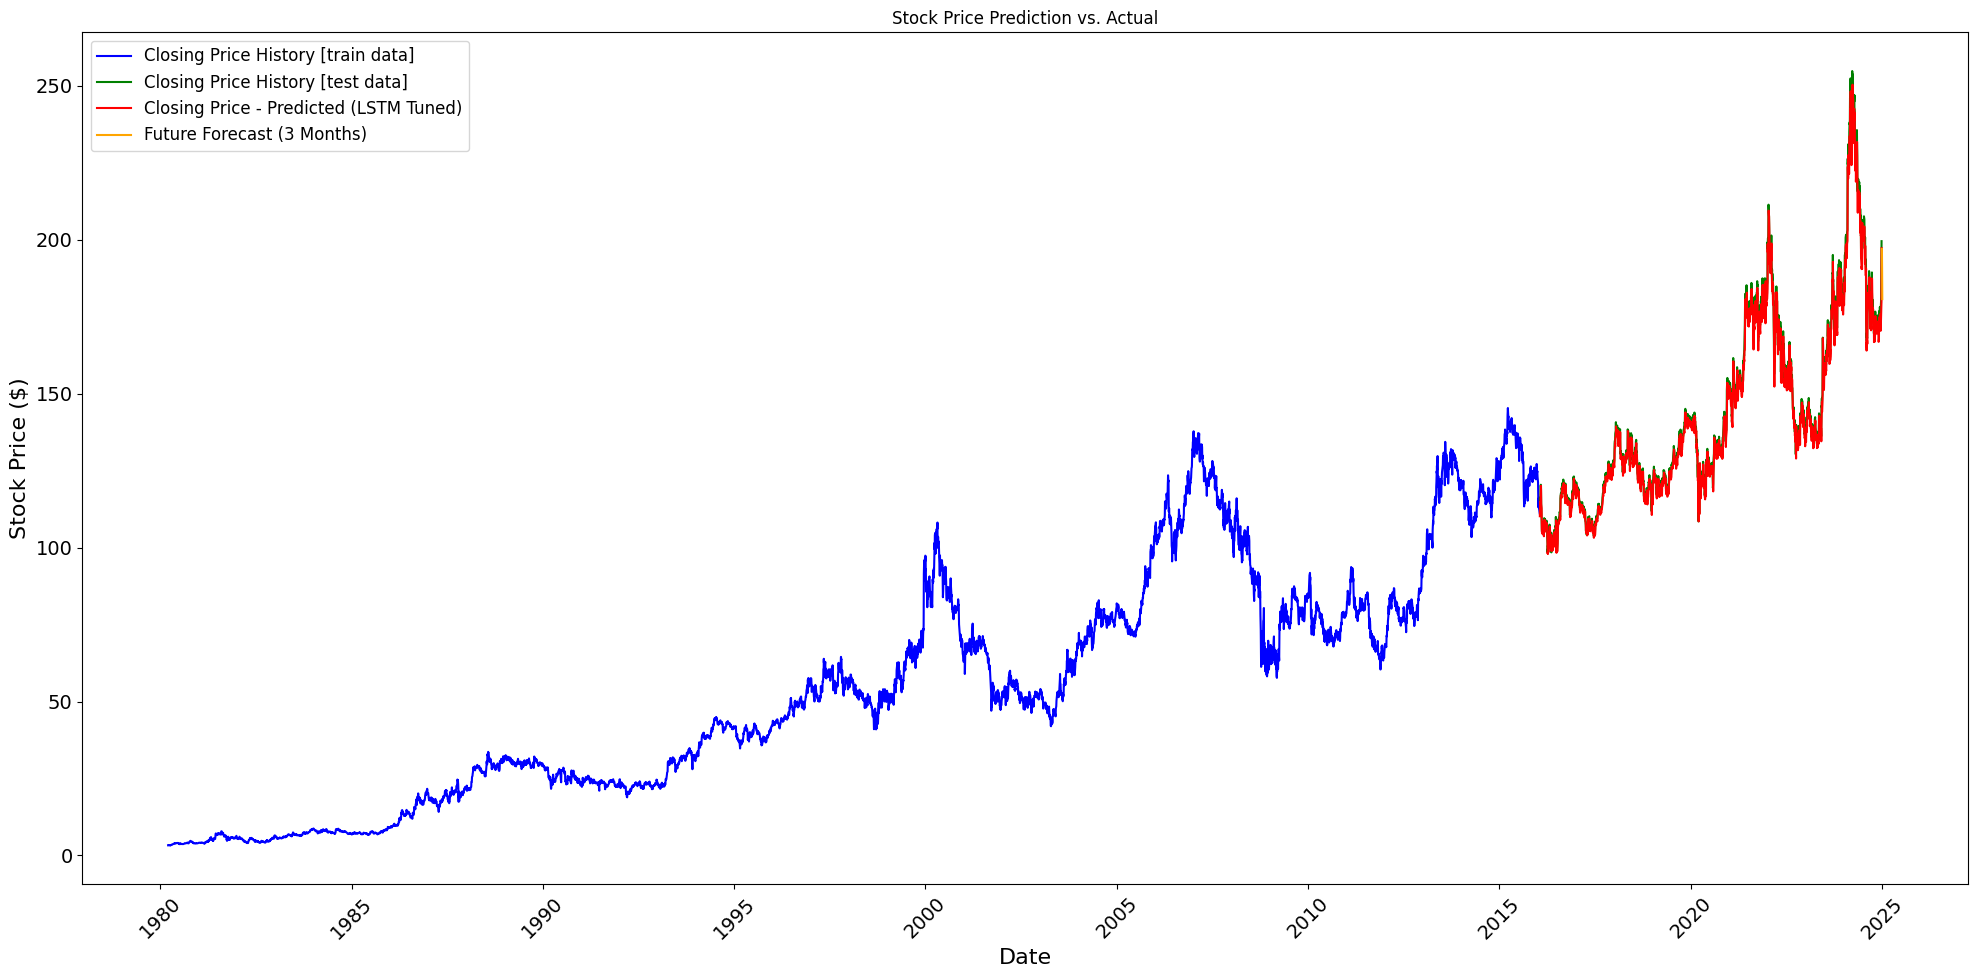

In [155]:
# Assuming 'test' DataFrame has 'Date', 'Close', and 'Predictions_lstm_tuned' columns
# and 'future_prices_df' DataFrame has 'Date' and 'Predicted_Close' columns from the previous code

plt.figure(figsize=(20, 10))
plt.xlabel('Date')
plt.ylabel('Stock Price ($)')

# Plot training data
plt.plot(train['Date'], train['Close'], label='Closing Price History [train data]', color='blue')

# Plot test data
plt.plot(test['Date'], test['Close'], label='Closing Price History [test data]', color='green')

# Plot predicted prices for the test data
plt.plot(test['Date'], test['Predictions_lstm_tuned'], label='Closing Price - Predicted (LSTM Tuned)', color='red')


# Plot future forecast
plt.plot(future_prices_df['Date'], future_prices_df['Predicted_Close'], label='Future Forecast (3 Months)', color='orange')

plt.legend(loc="upper left")
plt.title('Stock Price Prediction vs. Actual')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
